In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

In [2]:

if torch.cuda.is_available():
    dev = torch.device("cuda:0")
else:
    dev = torch.device("cpu")

# Import and normalize data

The dataset is available in the folder data of this repository. For detailed information please check the dataset datasheet in the file "data_sheet.md". It consists on a data file generated in Matlab (*.mat). To load it into python we use the convinient "io" toolbox from the scipy package. It loads the data in the .mat file into a dictionary.

In [ ]:
#load data from mat files
train_origin = loadmat('/Users/ricardo/Documents/VScode/brain_states/data/brain_state_trainset.mat')

val_origin = loadmat('/Users/ricardo/Documents/VScode/brain_states/data/brain_state_valset.mat')
test_origin = loadmat('/Users/ricardo/Documents/VScode/brain_states/data/brain_state_testset.mat')

For the windows version

In [210]:
#load data from mat files
train_origin = loadmat('Z:/ricardo/data/Project/State_classification/brain_state_trainset.mat')
val_origin = loadmat('Z:/ricardo/data/Project/State_classification/brain_state_valset.mat')
test_origin = loadmat('Z:/ricardo/data/Project/State_classification/brain_state_testset.mat')

In [611]:
train_origin = loadmat('Z:/ricardo/data/Project/State_classification/Reviewed_labels/brain_state_trainset.mat')
val_origin = loadmat('Z:/ricardo/data/Project/State_classification/Reviewed_labels/brain_state_valset.mat')

Check the content of the dictionary. We are interested in the 'spectrograms', 'movement' and 'target' keys. For each instance, there is a spectrogram of the power spectral density of LFP in the hippocampus at different lags from the reference time point (+- 50 s window around it). Likewise, "movement" gives the temporal profile of the magnitude of movement at the same time windows. The target variable contains the corresponding instance brain states labels. Namely, Wake, Quiet Wake, non-REM sleep and REM sleep (please check the dataset datasheet for more detailed information).

In [7]:
#check the content of the dictionary
train_origin.keys()

dict_keys(['__header__', '__version__', '__globals__', 'train_movement', 'train_spectrograms', 'train_target'])

### Data normalization

We are looking for a models that generalizes well across animals. So, the predictions should be robust to inter-subject variations in the absolute values of input variables. Typically, the movement data is quite reproducible accross animals, whereas the LFP power can have significant inter-subject variability.
Regarding LFP power spectrograms, there are two options: normalize using whole spectral data statistics or normalize each spectral image (such that all images will be normalized to the same range). In order to maximize generazability, the latter option will be adopted here.

**Normalization of movement data**

The different modalities and formats of LFP spectrograms and movement inputs makes it difficult to choose a normalization method that optimally balances the contribution of the two modalities. To avoid model biases due to data inballances, I will test two machine learning algorithms that don't use distance-based metrics and, in general, don't require data normalization: decision trees and artificial neural networks. In any case, the movement data will be range-normalized. 

In [5]:
from sklearn.preprocessing import RobustScaler

Normalize movement

In [328]:
x_norm = train_origin['train_movement'].flatten().reshape(-1,1)
moveScaler = RobustScaler(quantile_range=(10,90)).fit(x_norm)

In [615]:
def normalize_test(data_origin,spectr_field, mov_field, mov_scalefunc):

    #swap dimensions of spectrograms to have samples in the first dimension
    #l1 = np.shape(data_origin[spectr_field])
    #data_origin[spectr_field] = data_origin[spectr_field].reshape((l1[1],l1[0],l1[2]))

    #normalize spectral data using a quantile-based method that is not sensitive to outliers
    def normfunc(x):
        #center and normalize data based on percentiles 10 and 90
        transf = RobustScaler(quantile_range=(10,90)).fit(x)
        return transf.transform(x)


    spectral_norm = np.zeros((np.shape(data_origin[spectr_field])[1],np.shape(data_origin[spectr_field])[0],
    np.shape(data_origin[spectr_field])[2]))
    
    #normalize movement
    mov_norm = mov_scalefunc.transform(data_origin[mov_field].flatten().reshape(-1,1))
    mov_norm = np.reshape(mov_norm,(np.shape(data_origin[mov_field])))
    mov_norm = np.transpose(mov_norm) #transpose to have it in the form instances x movement profiles

    #Convert power spectral values to logarithms to minimize sekewness
    for i in range(np.shape(spectral_norm)[0]):
        spec = np.log(np.squeeze(data_origin[spectr_field][:,i,:]))
        #print(np.shape(spec))
        spec = normfunc(spec.flatten().reshape(-1,1)) #flatten the multidimensional data for normalization
        #spec = spec.flatten().reshape(-1,1)
        #spec = spec.ravel()
        #then recover the original format
        spectral_norm[i,:,:] = np.reshape(spec,(np.shape(spectral_norm)[1],np.shape(spectral_norm)[2]))
        if np.quantile(mov_norm[i,:],0.15)<0:
            mov_norm[i,:] = mov_norm[i,:]-np.quantile(mov_norm[i,:],0.15)

    #normalize movement data using the same approach, but now using whole dataset movement stats
    #mov_norm = normfunc(data_origin[mov_field].flatten().reshape(-1,1))
    #mov_norm = mov_scalefunc.transform(data_origin[mov_field].ravel())
    #mov_norm = np.reshape(mov_norm,(np.shape(data_origin[mov_field])))
    #mov_norm = np.transpose(mov_norm) #transpose to have it in the form instances x movement profiles

    return spectral_norm, mov_norm

In [616]:
#spectral_norm_train, mov_norm_train = normalize_test(train_origin,'train_spectrograms','train_movement',moveScaler)b
#spectral_norm_val, mov_norm_val = normalize_test(val_origin, 'val_spectrograms', 'val_movement',moveScaler)
spectral_norm_test, mov_norm_test = normalize_test(test_origin, 'test_spectrograms', 'test_movement',moveScaler)

In [617]:
spectral_norm_train, mov_norm_train = normalize_test(train_origin,'under_train_spectrograms','under_train_movement',moveScaler)
spectral_norm_val, mov_norm_val = normalize_test(val_origin, 'under_val_spectrograms', 'under_val_movement',moveScaler)

In [235]:
np.shape(train_origin['train_spectrograms'])

(101, 7328, 81)

In [100]:
train_origin.keys()

dict_keys(['__header__', '__version__', '__globals__', 'train_movement', 'train_spectrograms', 'train_target'])

### Visualize samples from different classes
Next we check how the data looks like for the different brain state classes.

In [199]:
train_origin['train_target'][8]

array([4], dtype=uint8)

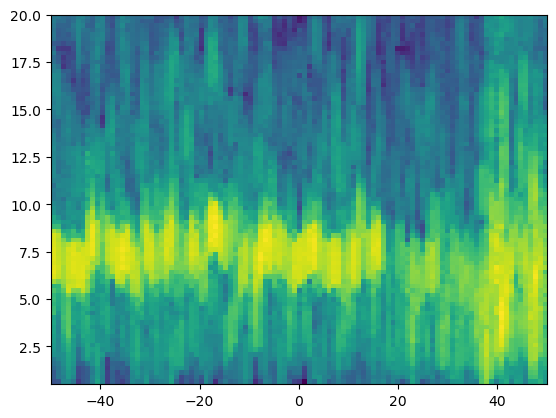

In [334]:
plt.imshow(spectral_norm_val[523,:,:].T, origin='lower',
    aspect='auto', extent=[-50,50,0.5,20])
plt.show()

(101, 81)


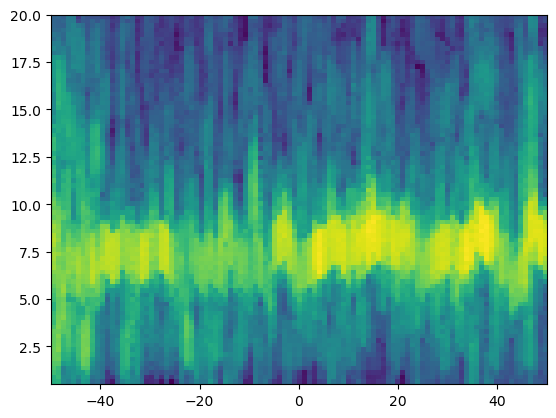

In [226]:
print(np.shape(np.squeeze(train_origin['train_spectrograms'][:,22,:])))
plt.imshow(np.log(train_origin['train_spectrograms'][:,22,:]).T, origin='lower',
    aspect='auto', extent=[-50,50,0.5,20])
plt.show()

[[300, 31, 219, 89]]


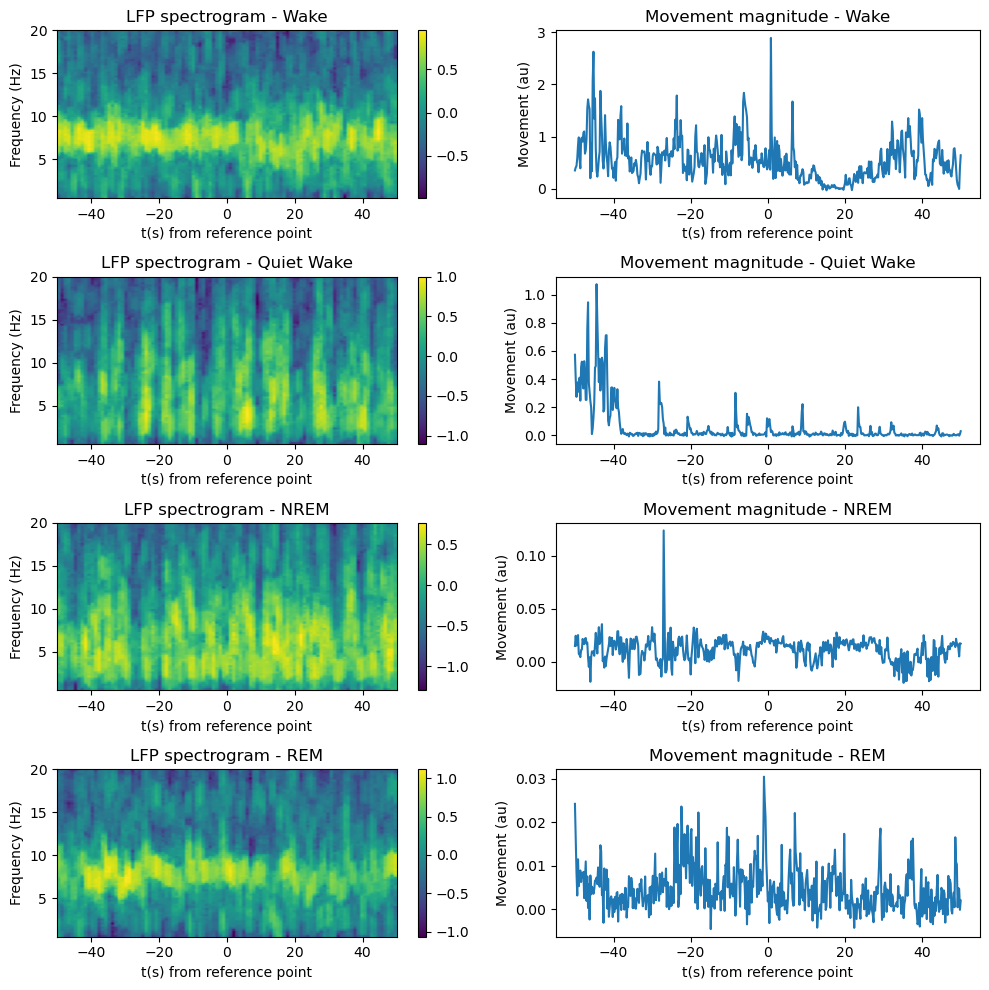

In [618]:
#pick indices corresponding to different classes
state_ind = [0, 0, 0, 0]
for i in np.arange(1,5):
    state_ind[i-1] = np.where(train_origin['under_train_target']==i)[0][np.random.randint(100)]
    #state_ind[i-1] = np.where(target_train_res==i)[0][np.random.randint(100)]

state_labels = ['Wake', 'Quiet Wake', 'NREM','REM']
fig, axs = plt.subplots(4,2, figsize=(10,10))
print([state_ind])

for i, labl in enumerate(state_labels):
    #plot spectral data
    pcm = axs[i,0].imshow(spectral_norm_train[state_ind[i],:,:].T, origin='lower',
    aspect='auto', extent=[-50,50,0.5,20])
    axs[i,0].set_title('LFP spectrogram - ' + labl)
    fig.colorbar(pcm, ax=axs[i,0])
    axs[i,0].set_xlabel('t(s) from reference point')
    axs[i,0].set_ylabel('Frequency (Hz)')
    
    #plot movement profile
    axs[i,1].plot(np.linspace(-50,50, num=501), mov_norm_train[state_ind[i],:])
    axs[i,1].set_title('Movement magnitude - ' + labl)
    axs[i,1].set_xlabel('t(s) from reference point')
    axs[i,1].set_ylabel('Movement (au)')

fig.tight_layout()
plt.show()

    

The examples ilustrate the difference in the patterns of LFP and movement across brain states. During Wake, the animal is moving (check magnitudes of movement) and there is a rythmic pattern of brain electrical activity in the hippocampus. It is called theta oscillation and underlies the spectral band visible at 6-10 Hz. During quiet wake both patterns are less accentuated and during NREM sleep there is little movement and no prominent theta band in LFP. This is distinct from the REM sleep patterns, showing strong theta in the absence of mevement.

## Correct unballanced data

An important aspect when dealing with data used in machine learning projects is whether the dataset is ballanced. Let's check how instances are distributed accross classes.

In [ ]:
counts_target,bins = np.histogram(train_origin['train_target'],bins=np.arange(0.5,5.5))
plt.bar(state_labels,counts_target)
plt.ylabel('Count')
plt.show()

The data is unballanced. To correct that we can use oversampling as shown below.

In [9]:
def oversample(data, spectra, mov, target_field,sampling='under'):
        
        from imblearn.over_sampling import RandomOverSampler
        from imblearn.under_sampling import RandomUnderSampler

        #The oversampling function only accepts instance x features format as inputs, 
        # so we need to reshape spectral data and concatenate it with movement
        X_data = np.concatenate((mov, spectra.reshape(len(mov),
                np.shape(spectra)[1]*np.shape(spectra)[2])),axis=1)
        y_data = data[target_field].ravel()

        #instantiate oversampler and apply it
        if sampling=='under':
                ros = RandomUnderSampler(random_state=34)
        elif sampling=='over':
                ros = RandomOverSampler(random_state=34)

        X_res, target_res = ros.fit_resample(X_data, y_data)

        #recover original data formats
        mov_norm_res = X_res[:,:np.shape(mov)[1]]
        spectral_norm_res = np.reshape(X_res[:, np.shape(mov)[1]:],
                (len(mov_norm_res),np.shape(spectra)[1],np.shape(spectra)[2]))

        return spectral_norm_res, mov_norm_res, target_res


In [337]:
spectral_norm_train_res, mov_norm_train_res, target_train_res = oversample(train_origin,spectral_norm_train, mov_norm_train,'train_target','under')
spectral_norm_val_res, mov_norm_val_res, target_val_res = oversample(val_origin,spectral_norm_val, mov_norm_val,'val_target', 'under')

In [620]:
spectral_norm_train_res, mov_norm_train_res, target_train_res = oversample(train_origin,spectral_norm_train, mov_norm_train,'under_train_target','under')
spectral_norm_val_res, mov_norm_val_res, target_val_res = oversample(val_origin,spectral_norm_val, mov_norm_val,'under_val_target','under')

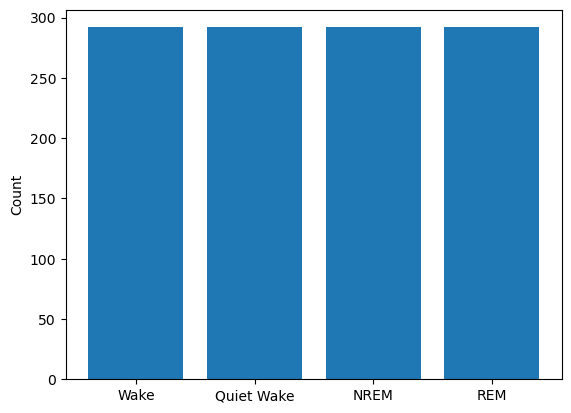

In [627]:
#confirm the new counts
counts_target,bins = np.histogram(target_val_res,bins=np.arange(0.5,5.5))
plt.bar(state_labels,counts_target)
plt.ylabel('Count')
plt.show()

## Create dataset object and random samplers

The dataset class from torch allows convenient storage and sampling of the data, particularly useful for neural network training.
First we need to create a class that will allow sampling batches of the dataset.

In [12]:
class DataStates(Dataset):
    def __init__(self, movement, spec, labels):
        self.labels = labels
        self.movement = movement
        self.spec = spec

    def __len__(self):
        return len(self.movement)

    def __getitem__(self, index):
        X1 = self.movement[index,:]
        X2 = self.spec[index,:,:]
        y = self.labels[index]
        return X1, X2, y


In [13]:
class DataStatesCUDA(Dataset):
    def __init__(self, movement, spec, labels):
        self.labels = labels
        self.movement = movement
        self.spec = spec

    def __len__(self):
        return len(self.movement)

    def __getitem__(self, index):
        X1 = self.movement[index, :,:]
        X2 = self.spec[index, :, :,:]
        y = self.labels[index]-1
        return X1, X2, y


Then we create the dataset object.

In [623]:
#Create datasets
#move training data to GPU
l1 = np.shape(mov_norm_train_res)
l2 = np.shape(spectral_norm_train_res)

mov_norm_trainCUDA = torch.tensor(mov_norm_train_res.reshape((l1[0],1,l1[1])),dtype=torch.float,device=dev)
spectral_norm_trainCUDA = torch.tensor(spectral_norm_train_res.reshape((l2[0],1,l2[1],l2[2])),dtype=torch.float, device=dev)
target_trainCUDA = torch.tensor(target_train_res,dtype=torch.long, device=dev)
data_train = DataStates(mov_norm_train_res, spectral_norm_train_res, target_train_res)
data_trainCUDA = DataStatesCUDA(mov_norm_trainCUDA, spectral_norm_trainCUDA, target_trainCUDA)
data_val = DataStates(mov_norm_val_res, spectral_norm_val_res, target_val_res)
data_test = DataStates(mov_norm_test, spectral_norm_test, test_origin['test_target'].ravel())



Then we create samplers that will randomly sample from pre-determined indices of the dataset, used to define training, validation and test sets.

In [14]:
np.random.seed(42)
indices = np.arange(len(data))
np.random.shuffle(indices) #shuffle indices before spliting into train, validation and test

#Allocate 40% of indices for training, and 30% each for validation and test 
n_train = int(len(data)*0.4)
ind_train = indices[:n_train]
n_val = int(len(data)*0.3)
ind_val = indices[n_train:n_train+n_val]
ind_test = indices[n_train+n_val:]
n_test = len(data)-(n_train+n_val)

#create partial data samplers
train_sampler = SubsetRandomSampler(ind_train,generator=torch.Generator().manual_seed(12))
val_sampler = SubsetRandomSampler(ind_val,generator=torch.Generator().manual_seed(12))
test_sampler = SubsetRandomSampler(ind_test,generator=torch.Generator().manual_seed(12))


NameError: name 'data' is not defined

# Make predictions using machine learning algorithms

I chose to address this problem using two approaches. The first is by means of a standard machine learning algorithm, namely decision tree. The decision tree (or tree ensembles) offers some advantages in the context of this challenge, relative to other machine learning algorithms: it is non-parametric and it does not rely on distance-based metrics. This is particularly important when considering to multi-modal nature of this dataset, where ballancing the weigth of movement and brain activity features is not easily achieved solely by normalization. 

## Fit Random Forest Classifier

We start by fitting a random forest model, a popular tree ensemble algorithm that overcomes some drawbacks of single decision trees, notably overfitting.

In [15]:
from sklearn import tree, ensemble
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [80]:
def random_forest(data_train, n_train, data_val, n_val, params = []):
    """Function that applies a random foresst classifier to the data.
    Inputs:
    train_sampler: sampler used to load the training data
    n_train: size of train set to fit
    validation_sampler: sampler used to load the validation data
    n_val: size of validation set to fit
    params: If not empty, it should be a series with the values corresponding to the parameters
    in n_estimators, max_depth, min_samples_leaf, max_features and min_impurity_decrease"""

    #create dataloaders
    #train_loader = DataLoader(data_train,batch_size=n_train,sampler=train_sampler)
    #validation_loader = DataLoader(data_val,batch_size=n_val,sampler=validation_sampler)
    train_loader = DataLoader(data_train,batch_size=n_train)
    validation_loader = DataLoader(data_val,batch_size=n_val)

    traindata = iter(train_loader)
    traindata = traindata.next()

    #train the model
    #we need to reshape the data such data for each instance there is a single row with all the features
    X_train = np.concatenate((traindata[0], 
    traindata[1].reshape(n_train,np.shape(traindata[1])[1]*np.shape(traindata[1])[2])),axis=1)
    y_train = traindata[2].ravel()

    if len(params)==0:
        rf_clf = ensemble.RandomForestClassifier()
    else:
        #print('here')
        rf_clf = ensemble.RandomForestClassifier(
            n_estimators=int(params['n_estimators']),
            max_depth=int(params["max_depth"]),
            min_samples_leaf=float(params['min_samples_leaf']),
            max_features=str(params['max_features']),
            min_impurity_decrease=float(params['min_impurity_decrease']))
            
    #fit the data
    #print(np.shape(X_train),np.shape(y_train))
    rf_clf.fit(X_train,y_train)

    #get validation data
    valdata = iter(validation_loader)
    valdata = valdata.next()
    
    #reshape
    X_val = np.concatenate((valdata[0], 
    valdata[1].reshape(n_val,np.shape(valdata[1])[1]*np.shape(valdata[1])[2])),axis=1)
    y_val = valdata[2].ravel()

    #make predictions
    pred = rf_clf.predict(X_val)

    #compute performance metrics
    cm = confusion_matrix(y_val,pred)
    score = rf_clf.score(X_val,y_val)

    return cm, score, rf_clf


Run the function with default settings

In [624]:
cm_rf_default, score_rf_default,rf_clf_default = random_forest(data_train, len(data_train), data_val, len(data_val))

Accuracy of the random forest is 0.89


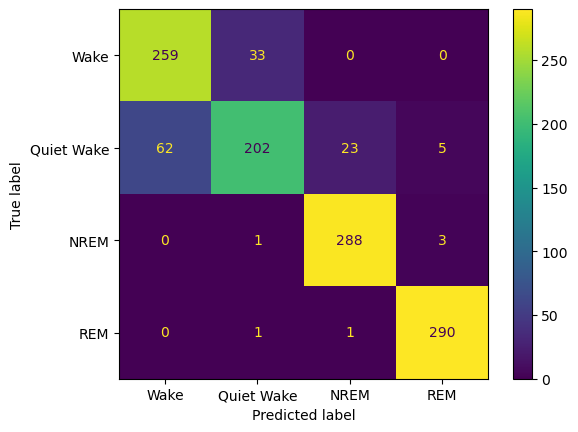

In [625]:
#Show performance
cmd_rf_default = ConfusionMatrixDisplay(cm_rf_default,display_labels=state_labels)
cmd_rf_default.plot();
print('Accuracy of the random forest is', np.round(score_rf_default,3))

It looks like we get quite a decent accuracy already with the default parameter values. Later we will tune the hyperparameters using Bayesian Optimisation.

# Build a neural network

Artificial neural networks have became popular due to their superior performance in solving complex problems. Among the many possible architectures, the convolutional neural networks (CNNs) are particularly suitable to deal with image formats of inputs. The CNNs hierarchical convolutions are able to capture important patterns in images while decreasing dimensionality. The end result is a model that learns to important features to solve the problem in a computational efficient way.
Here, I will design a CNN that operates on the bimodal inputs: the spectral images (2D) and movement (1D). The core idea is to pass the images throught two 2D convolution layers (with max pooling) whose output is fed into a series of fully connected layers until reaching the output layer. The movement 1D data will be addressed in parallel, passing though a 1D convolution filter (with max pooling). The inputs of 2D and 1D branches of the network intercept at the level of the first fully connected layer.

The network will be built applied using PyTorch.

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

**Implement the neural network class**

In [628]:
class Net(nn.Module):
    def __init__(self, name=None, filter_size1d=5, filter_size=5, fc1_size=120, fc2_size=84,n_conv1=6,n_conv2=16,n_convtime=3):
        """Define the convolutional neural network.
        The parameters describing filter sizes and the number of neurons in the fully connected
        layers can be provided externally.
        """
        
        super(Net,self).__init__()
        if name:
            self.name=name
        
        #define input size of first fully connected layer depending on image resolution
        global pool2h, pool2w, pooltimew, num_conv2

        num_conv2 = n_conv2
        picres = torch.tensor([[101,81]]) #tensor with image resolution for spectral data

        pool1h = torch.floor(((picres[0][0]-(filter_size-1))-2)/2)+1 #height of 1st maxpool layer output
        pool2h = torch.floor(((pool1h-(filter_size-1))-2)/2)+1 #height of 2nd maxpool layer output
        pool1w = torch.floor(((picres[0][1]-(filter_size-1))-2)/2)+1 #width of 1st maxpool layer output
        pool2w = torch.floor(((pool1w-(filter_size-1))-2)/2)+1 #width of 2nd maxpool layer output
        
        #branch of spectral images
        self.conv1=nn.Conv2d(1,n_conv1,filter_size) #set a fixed number of filters of 6
        self.pool=nn.MaxPool2d(2,2) #max-pooling parameters are fixed
        self.conv2=nn.Conv2d(n_conv1,n_conv2,filter_size) #fixed number of filters 16

        #branch of movement
        self.convtime = nn.Conv1d(1,n_convtime,filter_size1d) #use 3 1d convolution filters 
        self.pooltime = nn.MaxPool1d(2,2) #max-pooling
        pooltimew = torch.floor(((torch.tensor(501)-(filter_size1d-1))-2)/2)+1 #width of the max-pool output

        #fully connected layers
        #the first layer gets the inputs of the 2D branch concatenated with those from the 1D branch
        self.fc1=nn.Linear(int(n_conv2*pool2h.item()*pool2w.item())+int(n_convtime*pooltimew.item()),fc1_size)
        self.fc2=nn.Linear(fc1_size,fc2_size) #second fully connected layer
        self.fc3=nn.Linear(fc2_size,4) #output layer
        

    def forward(self, x, x2):
        #x denotes the spectral inputs and x2 denotes movement inputs
        #the output of all convolution layers passes trhough a ReLu activation function
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, int(num_conv2*pool2h.item()*pool2w.item()))
        x2 = self.pooltime(F.relu(self.convtime(x2)))
        x2 = x2.reshape(np.shape(x2)[0],np.shape(x2)[1]*np.shape(x2)[2])
        
        #the output of the 2 fully connect hidden-layers goes through ReLu activation
        x = F.relu(self.fc1(torch.concat((x, x2),dim=1)))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x)) #output layer
        return x

## Training the neural network

### Training function

In [666]:
def trainNet(net, data_train, batch_size=10, epochs=4, epoch_start=0, printr=False, save_loss=False):
    """Function to train the neural network
        Inputs:
            net: network to train
            batch_size: size of the mini-batch used in the SGD optimization
            epochs: number of traning epochs
            epoch start: number of epochs run so far + 1. Used to keep track of total training
                epochs when the function takes an already pretrained network as input
            printr: boolean to determine whether running loss is displayed during execution
            save_loss: boolean used to indicate wheter to store information about the running loss"""
 
    net = net.float()
    net.to(dev)

    # create training loader
    trainloader = DataLoader(data_train,batch_size=int(batch_size))

    #train
    import time 
    start = time.time()
    global loss
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        
        epoch_start += 1
        running_loss = 0.0
        rloss = []
        
        for i, sample in enumerate(trainloader):
            #l1 = np.shape(sample[0])
            #l2 = np.shape(sample[1])

            #print(type(sample[0]),type(sample[1]))
            #get the inputs with the approppriate shape for the network function
            #input_mov = torch.tensor(sample[0].reshape((l1[0],1,l1[1])),dtype=torch.float,device=dev)
            #input_spec = torch.tensor(sample[1].reshape(l2[0],1,l2[1],l2[2]),dtype=torch.float,device=dev)
            #labels = torch.tensor(sample[2]-1, dtype=torch.long,device=dev)
            #print(type(input_mov))
            
            # zero the parameter gradients
            optimizer.zero_grad()

            #compute network output
            #outputs=net(input_spec,input_mov)
            outputs=net(sample[1],sample[0])
            
            #print(np.shape(sample[2]))
            #calculate loss (criterion is a global variable initialized externaly)
            loss = criterion(outputs, sample[2])
            
            #update weights based on backpropagation
            loss.backward()
            optimizer.step()

            if save_loss:
                rloss.append(loss.item())

            if printr:
                # print statistics
                running_loss += loss.item()
                if i % 10 == 9:    # print every 10 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 10))
                    running_loss = 0.0
    
    end = time.time()

    if printr:
        print('Finished Training')
        print('training time ', end-start)
    
    if save_loss:
        return rloss

### Save checkpoint function

Function used to save current model state and related paraments into a file.

In [22]:
def SaveCheckpoint(tuning, path):
    torch.save({
        'tuned_parameters': tuning.best_x,
        'tuning_data': tuning,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    },path)

### Checkpoint function

Function used to instantiate the intialize either a new neural network or taking a pre-saved model 

In [787]:
def Checkpoint(path, name=None, filter_size1d=5, filter_size=5, fc1_size=120, fc2_size=84, lr=0.0005,n_conv1=6,n_conv2=16,n_convtime=3):
    """Function used to instantiate the intialize either a new neural network or taking a pre-saved model
            Inputs:
                path: path of the file containing model information(saved with the SaveCheckpoint function
                name: network name
                filter_size1d, filter_size, fc1_size, fc2_size are network hyperparameters
                lr: learning rate"""
                
    #instantiate neural network
    global net,criterion,optimizer,epoch_start
    
    #print(filter_size1d)
    net = Net(name, filter_size1d, filter_size, fc1_size, fc2_size, n_conv1, n_conv2, n_convtime).float().to(dev)
    
    #create optimizer
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([1,10,1,1],dtype=torch.float,device=dev))
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.95)
    
    if path == '':
        epoch_start = 0
        #loss = torch.zeros(1,requires_grad=True)
    else:
        checkpt = torch.load(path)
        filter_size1d=int(checkpt['tuned_parameters']['filter_size1d'])
        filter_size = int(checkpt['tuned_parameters']['filter_size'])
        fc1_size = int(checkpt['tuned_parameters']['fc1_size'])
        fc2_size = int(checkpt['tuned_parameters']['fc2_size'])
        print(filter_size1d)
        net = Net(name, filter_size1d, filter_size, fc1_size, fc2_size)
        
        net.load_state_dict(checkpt['model_state_dict'])
        optimizer.load_state_dict(checkpt['optimizer_state_dict'])
        #epoch_start = checkpt['epoch']
        loss = checkpt['loss']
        net.train()

### Network test function

Next, we define a function to run to test the predictive performance of the CNN on the validation and test sets.

In [558]:
def test(net, data,batch_size=10, printr=False):
    """Function to test neural network predictions on a given dataset
            Inputs:
                net: Network to test
                sampler: Subset random sampler used to sample validation or test sets
                batch_size: size of batchs to compute predictions on
                printr: Whether to show performance results"""

    testloader = DataLoader(data,batch_size=batch_size)
    net = net.float()
    net.to(torch.device('cpu'))
    
    correct = 0
    total = 0
    with torch.no_grad():
        for sample in testloader:
            l1 = np.shape(sample[0])
            l2 = np.shape(sample[1])
            #reshaope input data to approppriate format
            input_mov = torch.tensor(sample[0].reshape((l1[0],1,l1[1])),dtype=torch.float)
            input_spec = torch.tensor(sample[1].reshape(l2[0],1,l2[1],l2[2]),dtype=torch.float)
            labels = sample[2]-1
            
            #compute predictions from the class with max output
            outputs=net(input_spec,input_mov)
            predicted = np.argmax(outputs,axis=1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    #compute confusion matrix
    cm = confusion_matrix(labels,predicted)
    
    if printr:
        print(cm)
        print('Accuracy:\nTotal:', 100*correct/total, '\nWake:',cm[0,0]/np.sum(cm[0,:]),'\nQuiet wake:',
        cm[1,1]/np.sum(cm[1,:]),'\nNREM:', cm[2,2]/np.sum(cm[2,:]),'\nREM:', cm[3,3]/np.sum(cm[3,:]))
        
    return cm, 100*correct/total, predicted, outputs

In [64]:
print(type(spectral_norm_trainCUDA))
print(type(net))

<class 'torch.Tensor'>
<class '__main__.Net'>


In [794]:
Checkpoint('', name='Net-Capstone', lr=0.0005, n_conv1=11,n_conv2=9,n_convtime=2,fc1_size=800,fc2_size=700, filter_size=14, filter_size1d=14)


trainNet(net,data_trainCUDA, epochs=300,batch_size=100,printr=True)


[1,    10] loss: 1.388
[2,    10] loss: 1.388
[3,    10] loss: 1.387
[4,    10] loss: 1.387
[5,    10] loss: 1.387
[6,    10] loss: 1.386
[7,    10] loss: 1.386
[8,    10] loss: 1.386
[9,    10] loss: 1.386
[10,    10] loss: 1.385
[11,    10] loss: 1.385
[12,    10] loss: 1.385
[13,    10] loss: 1.384
[14,    10] loss: 1.384
[15,    10] loss: 1.384
[16,    10] loss: 1.384
[17,    10] loss: 1.383
[18,    10] loss: 1.383
[19,    10] loss: 1.383
[20,    10] loss: 1.382
[21,    10] loss: 1.382
[22,    10] loss: 1.382
[23,    10] loss: 1.383
[24,    10] loss: 1.384
[25,    10] loss: 1.386
[26,    10] loss: 1.389
[27,    10] loss: 1.391
[28,    10] loss: 1.390
[29,    10] loss: 1.377
[30,    10] loss: 1.352
[31,    10] loss: 1.318
[32,    10] loss: 1.280
[33,    10] loss: 1.237
[34,    10] loss: 1.202
[35,    10] loss: 1.174
[36,    10] loss: 1.144
[37,    10] loss: 1.118
[38,    10] loss: 1.099
[39,    10] loss: 1.092
[40,    10] loss: 1.075
[41,    10] loss: 1.093
[42,    10] loss: 1.065
[

In [795]:

test(net,data_val, batch_size=len(data_val),printr=True)

[[257  35   0   0]
 [ 51 209  27   5]
 [  0   0 291   1]
 [  0   1   1 290]]
Accuracy:
Total: 89.64041095890411 
Wake: 0.8801369863013698 
Quiet wake: 0.7157534246575342 
NREM: 0.9965753424657534 
REM: 0.9931506849315068


(array([[257,  35,   0,   0],
        [ 51, 209,  27,   5],
        [  0,   0, 291,   1],
        [  0,   1,   1, 290]], dtype=int64),
 89.64041095890411,
 tensor([0, 0, 1,  ..., 3, 3, 3]),
 tensor([[9.9933e-01, 6.7260e-04, 2.6998e-21, 1.0980e-12],
         [1.0000e+00, 5.8896e-08, 2.9056e-31, 6.1646e-23],
         [3.8004e-01, 6.1996e-01, 2.0209e-12, 1.2417e-06],
         ...,
         [7.3590e-09, 1.8341e-13, 2.7989e-06, 1.0000e+00],
         [5.3239e-10, 1.9311e-14, 7.2674e-08, 1.0000e+00],
         [8.3068e-09, 5.8544e-14, 2.1535e-07, 1.0000e+00]]))

# Hyperparameter tuning with HEBO

In order to maximize the performance of the models, it is important to tune their hyperparameters. However, evaluation of machine learning models can be computationaly expensive, particularly in the case of artificial neural networks. Therefore, in order to minimize the time and resources spent in hyperparameter tuning, it is critical to use a data guided approach such as Bayesian Optimisation (BO). In this section, I will use a state-of-the-art Baysian Optimisation algorithm named HEBO (standing for Heteroscedastic Evolutionary Bayesian Optimisation). This algorithm was developed by a HUAWEI team, who won a NeurIPS black-box competion. It improves some limitations of standard BO by assuming non-stationarity and complex amplitude-dependent noise of the black-box function (for details please check the package repository under https://github.com/huawei-noah/HEBO/tree/master/HEBO).

## Tune the neural network

In [27]:
from hebo.optimizers.hebo import HEBO
from hebo.optimizers.bo import BO
from hebo.optimizers.hebo_embedding import HEBO_Embedding
from hebo.design_space.design_space import DesignSpace

### Wraper function to use in the tuning

It is useful to define a function that returns the performance of the CNN on the validation set, given a set of hyperparameter values.

In [448]:
def netlearn(filter_size1d=3, filter_size=3, fc1_size=120, fc2_size=84, lr=0.001, epochs=100, batch_size=100,n_conv1=16,n_conv2=6,n_convtime=3):
    
    Checkpoint('', name='Net-Capstone', filter_size1d=filter_size1d,
     filter_size=filter_size, fc1_size=fc1_size, fc2_size=fc2_size, lr=lr, n_conv1=n_conv1,n_conv2=n_conv2,n_convtime=n_convtime)
    
    trainNet(net, data_trainCUDA, epochs=epochs, batch_size=batch_size)
    _,performance = test(net,data_val, batch_size=len(data_val))
    
    return performance
    

Design the input space 

In [453]:
# space = DesignSpace().parse([{'name':'filter_size1d','type':'int','lb': 3, 'ub': 20},
#                             {'name':'filter_size','type':'int','lb': 5, 'ub': 20},
#                             {'name':'fc1_size','type':'int','lb': 50, 'ub': 500},
#                            {'name':'fc2_size','type':'int','lb': 50, 'ub': 500},
#                            {'name':'lr','type':'pow','lb': 1e-5, 'ub': 1e-3},
#                            {'name':'epochs','type':'int','lb': 30, 'ub': 100},
#                            {'name':'batch_size','type':'int','lb': 50, 'ub': 100},
#                            ])

space = DesignSpace().parse([{'name':'filter_size1d','type':'int','lb': 3, 'ub': 20},
                            {'name':'filter_size','type':'int','lb': 5, 'ub': 20},
                            {'name':'fc1_size','type':'int','lb': 100, 'ub': 800},
                           {'name':'fc2_size','type':'int','lb': 80, 'ub': 700},
                           {'name':'n_conv1','type':'int','lb': 6, 'ub': 16},
                           {'name':'n_conv2','type':'int','lb': 3, 'ub': 10},
                           {'name':'n_convtime','type':'int','lb': 1, 'ub': 5},
                           ])

#Instantiate HEBO optimizer
hebo = HEBO(space)


In [456]:

#Define wrapper function
def obj(X):
    return netlearn(filter_size1d=X.iloc[0,0],filter_size=X.iloc[0,1],
     fc1_size=X.iloc[0,2],fc2_size=X.iloc[0,3],n_conv1=X.iloc[0,4],n_conv2=X.iloc[0,5],n_convtime=X.iloc[0,6])
    #return netlearn(filter_size1d=X['filter_size1d'][0],filter_size=X['filter_size'][0],
    #fc1_size=X['fc1_size'][0],fc2_size=X['fc2_size'][0],n_conv1=X['n_conv1'][0],n_conv2=X['n_conv2'][0],n_convtime=X['n_convtime'][0])

Run Bayesian Optimization

In [455]:
x_rec

,filter_size1d,filter_size,fc1_size,fc2_size,n_conv1,n_conv2,n_convtime
14,15,9,779,269,9,10,4


In [457]:
for i in range(42):
    x_rec = hebo.suggest() #suggest new data point based on observations made so far
    hebo.observe(x_rec,-np.reshape(obj(x_rec),(-1,1))) #add new data point
    if i % 1 == 0:
        print('Iter %d, best_y = %.2f, y = %.2f' % (i, -hebo.y.min(),-hebo.y[i]))

Iter 0, best_y = 89.11, y = 81.85
Iter 1, best_y = 89.11, y = 87.54
Iter 2, best_y = 89.11, y = 85.81
Iter 3, best_y = 89.11, y = 87.05
Iter 4, best_y = 89.11, y = 85.81
Iter 5, best_y = 89.11, y = 84.41
Iter 6, best_y = 89.11, y = 89.11
Iter 7, best_y = 89.11, y = 85.81
Iter 8, best_y = 89.11, y = 88.61
Iter 9, best_y = 89.11, y = 86.22
Iter 10, best_y = 89.11, y = 85.64
Iter 11, best_y = 89.11, y = 87.95
Iter 12, best_y = 89.11, y = 86.72
Iter 13, best_y = 89.11, y = 86.72
Iter 14, best_y = 89.11, y = 87.46
Iter 15, best_y = 89.11, y = 85.31
Iter 16, best_y = 89.11, y = 85.97
Iter 17, best_y = 89.11, y = 86.30
Iter 18, best_y = 89.11, y = 88.53
Iter 19, best_y = 89.11, y = 85.15
Iter 20, best_y = 89.11, y = 87.29
Iter 21, best_y = 89.11, y = 88.94
Iter 22, best_y = 90.10, y = 88.94
Iter 23, best_y = 90.10, y = 88.37
Iter 24, best_y = 90.10, y = 87.46
Iter 25, best_y = 90.10, y = 88.61
Iter 26, best_y = 90.10, y = 88.61
Iter 27, best_y = 90.10, y = 82.10
Iter 28, best_y = 90.10, y = 8

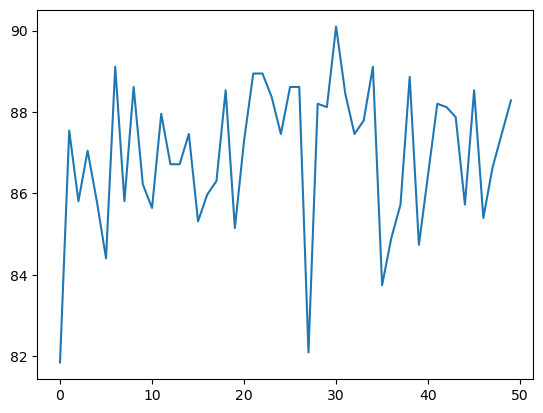

In [458]:
plt.plot(range(50),-hebo.y)
plt.show()

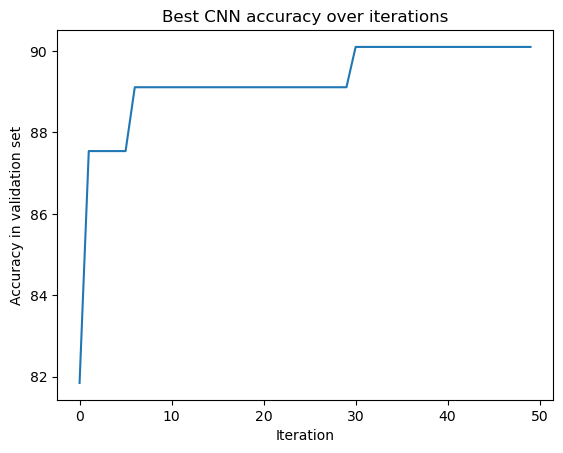

In [459]:
#Plot the change of the best accuracy over iterations
plt.plot(range(len(hebo.y)), -np.minimum.accumulate(hebo.y))
plt.title('Best CNN accuracy over iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy in validation set')
plt.show()

In [32]:
print('Best CNN accuracy was', np.round(-hebo.best_y,3))

Best CNN accuracy was 87.376


It seems that we got quite a good performance after BO. Let's check the hyperparameter values that led to the best accuracy.

In [460]:
hebo.best_x

,filter_size1d,filter_size,fc1_size,fc2_size,n_conv1,n_conv2,n_convtime
30,14,14,492,541,11,9,2


The best performance was achieved with the limit of the specified range of epochs (20). Now, we can check how is the performance of this model changing as a function of epochs in more detail

In [50]:
#We sample the performance in the validation set each 10 epochs
filter_sizes = np.ones(5,dtype=np.int)*20
acc_vs_filtersize = []
for siz in filter_sizes:
      Checkpoint('', name='Net-Capstone', filter_size1d=int(hebo.best_x['filter_size1d']),
     filter_size=siz, fc1_size=int(hebo.best_x['fc1_size']),
      fc2_size=int(hebo.best_x['fc2_size']), lr=float(hebo.best_x['lr']))

      net_loss= trainNet(net, data_trainCUDA, epochs=int(hebo.best_x['epochs']), batch_size=int(hebo.best_x['batch_size']))
      _,acci = test(net,data_val, batch_size=len(data_val),printr=True)
      acc_vs_filtersize.append(acci)

[[238  62   1   2]
 [ 29 202   4  68]
 [  0   0   0 303]
 [  0   0   0 303]]
Accuracy:
Total: 61.303630363036305 
Wake: 0.7854785478547854 
Quiet wake: 0.6666666666666666 
NREM: 0.0 
REM: 1.0
[[207  92   3   1]
 [ 15 187  64  37]
 [  0   1  12 290]
 [  0   0  16 287]]
Accuracy:
Total: 57.17821782178218 
Wake: 0.6831683168316832 
Quiet wake: 0.6171617161716172 
NREM: 0.039603960396039604 
REM: 0.9471947194719472
[[268  33   0   2]
 [ 57 194  15  37]
 [  0   4   7 292]
 [  0   1   0 302]]
Accuracy:
Total: 63.613861386138616 
Wake: 0.8844884488448845 
Quiet wake: 0.6402640264026402 
NREM: 0.0231023102310231 
REM: 0.9966996699669967
[[236  58   9   0]
 [ 25 137 141   0]
 [  0   0 303   0]
 [  0   0 303   0]]
Accuracy:
Total: 55.775577557755774 
Wake: 0.7788778877887789 
Quiet wake: 0.4521452145214521 
NREM: 1.0 
REM: 0.0
[[285  17   0   1]
 [ 86 173  14  30]
 [  0   4   7 292]
 [  0   4   3 296]]
Accuracy:
Total: 62.788778877887786 
Wake: 0.9405940594059405 
Quiet wake: 0.570957095709571 


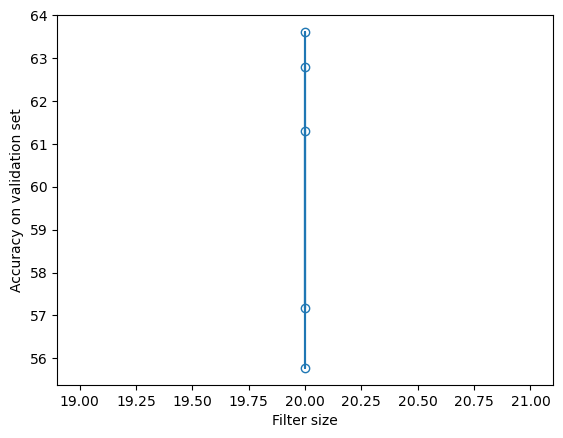

In [51]:
plt.plot((filter_sizes[:len(acc_vs_filtersize)]),acc_vs_filtersize,marker='o', fillstyle = 'none')
plt.xlabel('Filter size')
plt.ylabel('Accuracy on validation set')
plt.show()

It looks like the performance stabilizes above 30 epochs. So, we can take the latest network state after 50 epochs.

In [675]:
hebo.best_x

,filter_size1d,filter_size,fc1_size,fc2_size,n_conv1,n_conv2,n_convtime
30,14,14,492,541,11,9,2


In [746]:
#test performance in validation set
Checkpoint('', name='Net-Capstone', filter_size1d=int(hebo.best_x['filter_size1d']),
    filter_size=int(hebo.best_x['filter_size']), fc1_size=int(hebo.best_x['fc1_size']),
     fc2_size=int(hebo.best_x['fc2_size']), lr=0.0005, n_conv1=int(hebo.best_x['n_conv1']),
     n_conv2=int(hebo.best_x['n_conv2']),n_convtime=int(hebo.best_x['n_convtime']))


In [757]:

net_loss= trainNet(net, data_trainCUDA, epochs=100, batch_size=100,printr=True)

cm_CNNtuned, acc_CNNtuned, _, _  = test(net,data_val, batch_size=len(data_val))

[1,    10] loss: 0.780
[2,    10] loss: 0.780
[3,    10] loss: 0.780
[4,    10] loss: 0.780
[5,    10] loss: 0.780
[6,    10] loss: 0.780
[7,    10] loss: 0.780
[8,    10] loss: 0.780
[9,    10] loss: 0.780
[10,    10] loss: 0.780
[11,    10] loss: 0.780
[12,    10] loss: 0.780
[13,    10] loss: 0.780
[14,    10] loss: 0.780
[15,    10] loss: 0.780
[16,    10] loss: 0.780
[17,    10] loss: 0.780


KeyboardInterrupt: 

In [756]:
plt.plot(range(len(net_loss)),net_loss)
plt.show()

TypeError: object of type 'NoneType' has no len()

Accuracy of the CNN is 90.24


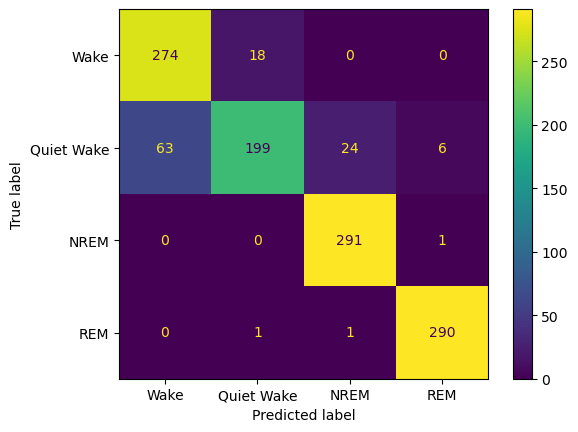

In [754]:
#Show performance
cmd_CNN = ConfusionMatrixDisplay(cm_CNNtuned,display_labels=state_labels)
cmd_CNN.plot();
print('Accuracy of the CNN is', np.round(acc_CNNtuned,3))

In [464]:
#save model checkpoint
path_check = 'D:/Ricardo/code/brain_states/net-brain_states.pt'
SaveCheckpoint(hebo,path_check)

## Tune the random forest

In [803]:
#Create optimisation space object for HEBO 
space_rf = DesignSpace().parse([{'name':'n_estimators','type':'cat','categories': [100, 200, 500, 1000]},
                            {'name':'max_depth','type':'int','lb': 5, 'ub': 30},
                            {'name':'min_samples_leaf','type':'num','lb': 1e-5, 'ub': 0.1},
                            {'name':'max_features','type':'cat','categories': ['log2', 'sqrt']},
                           {'name':'min_impurity_decrease','type':'pow','lb': 1e-5, 'ub': 0.1},
                           ])

#Instantiate the HEBO optimiser
hebo_rf = HEBO(space_rf)

#Define a wrapper function to evaluate the random forest classifier 
def obj(X):
    _, perf,_ = random_forest(data_train, len(data_train),data_val, len(data_val),(X.iloc[0,:]))
    return perf

Run Bayesian Optimisation

In [75]:
x_rec

,max_depth,min_samples_leaf,min_impurity_decrease,n_estimators,max_features
0,1,0.0001,0.0001,100,log2


In [804]:
for i in range(50):
    x_rec = hebo_rf.suggest()
    hebo_rf.observe(x_rec,-np.reshape(obj(x_rec),(-1,1)))
    if i % 1 == 0:
        print('Iter %d, best_y = %.2f, y = %.2f' % (i, -hebo_rf.y.min(),-hebo_rf.y[i]))

Iter 0, best_y = 0.87, y = 0.87
Iter 1, best_y = 0.87, y = 0.84
Iter 2, best_y = 0.88, y = 0.88
Iter 3, best_y = 0.88, y = 0.81
Iter 4, best_y = 0.88, y = 0.85
Iter 5, best_y = 0.88, y = 0.84
Iter 6, best_y = 0.88, y = 0.86
Iter 7, best_y = 0.89, y = 0.89
Iter 8, best_y = 0.90, y = 0.90
Iter 9, best_y = 0.90, y = 0.90
Iter 10, best_y = 0.90, y = 0.75
Iter 11, best_y = 0.90, y = 0.90
Iter 12, best_y = 0.90, y = 0.89
Iter 13, best_y = 0.90, y = 0.90
Iter 14, best_y = 0.90, y = 0.90
Iter 15, best_y = 0.90, y = 0.90
Iter 16, best_y = 0.90, y = 0.90
Iter 17, best_y = 0.90, y = 0.90
Iter 18, best_y = 0.90, y = 0.84
Iter 19, best_y = 0.90, y = 0.81
Iter 20, best_y = 0.90, y = 0.90
Iter 21, best_y = 0.90, y = 0.90
Iter 22, best_y = 0.90, y = 0.90
Iter 23, best_y = 0.90, y = 0.90
Iter 24, best_y = 0.90, y = 0.90
Iter 25, best_y = 0.90, y = 0.90
Iter 26, best_y = 0.90, y = 0.89
Iter 27, best_y = 0.90, y = 0.90
Iter 28, best_y = 0.91, y = 0.91
Iter 29, best_y = 0.91, y = 0.89
Iter 30, best_y = 0.

KeyboardInterrupt: 

### Check results

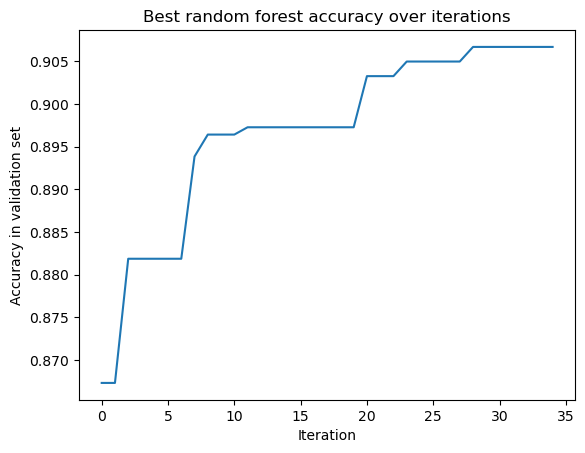

In [805]:
#Plot the change of the best accuracy over iterations
plt.plot(range(len(hebo_rf.y)), -np.minimum.accumulate(hebo_rf.y))
plt.title('Best random forest accuracy over iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy in validation set')
plt.show()

In [806]:
#Check the hyperparameter values that gave the best accuracy
hebo_rf.best_x

,max_depth,min_samples_leaf,min_impurity_decrease,n_estimators,max_features
28,28,0.00001,0.000012,1000,sqrt


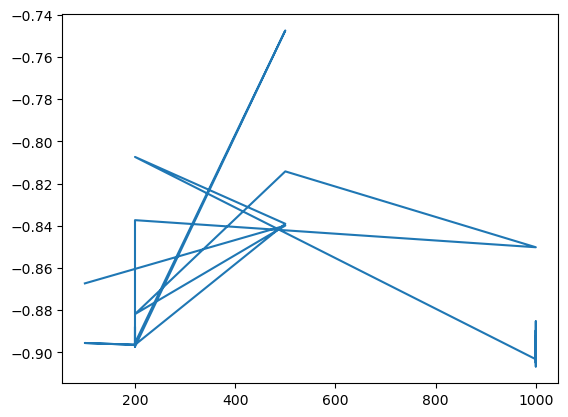

In [807]:
plt.plot(hebo_rf.X['n_estimators'],hebo_rf.y)
plt.show()

In [808]:
cm_rf_tuned, acc_rf_tuned,_ = random_forest(data_train, len(data_train), data_val,len(data_val), hebo_rf.best_x.iloc[0,:])

Accuracy of the Random Forest is 0.904


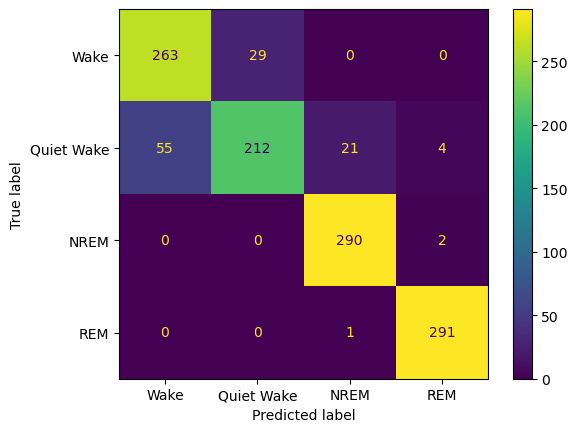

In [809]:
#Show performance
cmd_rf_tuned = ConfusionMatrixDisplay(cm_rf_tuned,display_labels=state_labels)
cmd_rf_tuned.plot();
print('Accuracy of the Random Forest is', np.round(acc_rf_tuned,3))

# Model selection

After tuning both models, we can now compare their performance in the test set.

### Test models' predictive performance on the test set

For the random forest model

In [810]:
cm_rf_test, accuracy_rf_test, best_rf = random_forest(data_train, len(data_train), data_test, len(data_test), hebo_rf.best_x.iloc[0,:])

Accuracy of the Random Forest is 0.938


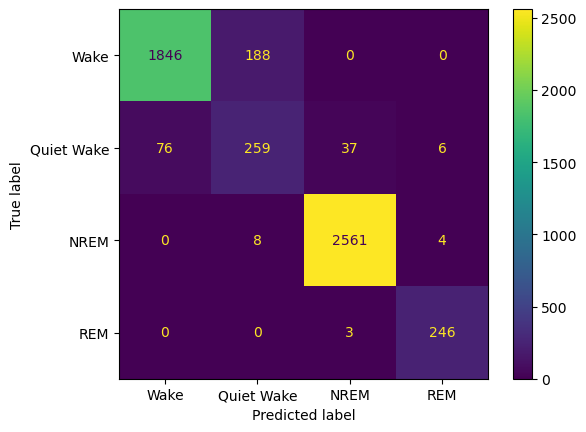

In [811]:
#Show performance
cmd_rf_test = ConfusionMatrixDisplay(cm_rf_test,display_labels=state_labels)
cmd_rf_test.plot();
print('Accuracy of the Random Forest is', np.round(accuracy_rf_test,3))

For the neural network

In [465]:
#test performance in vali
cm_CNNtest, acc_CNNtest = test(net,data_test, batch_size=len(data_test))

Accuracy of the CNN on the test set is 91.842


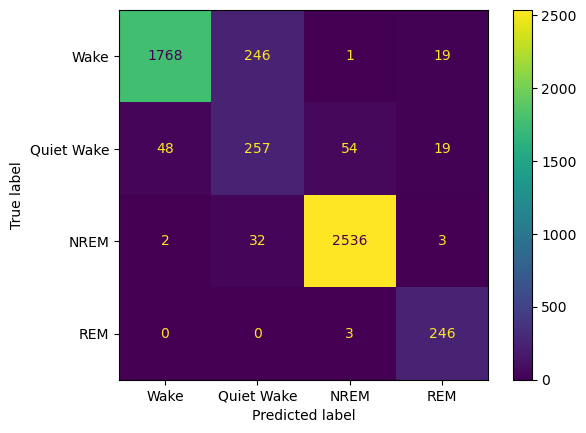

In [466]:
#Show performance
cmd_CNNtest = ConfusionMatrixDisplay(cm_CNNtest,display_labels=state_labels)
cmd_CNNtest.plot();
print('Accuracy of the CNN on the test set is', np.round(acc_CNNtest,3))

### Compare accuracy accross states

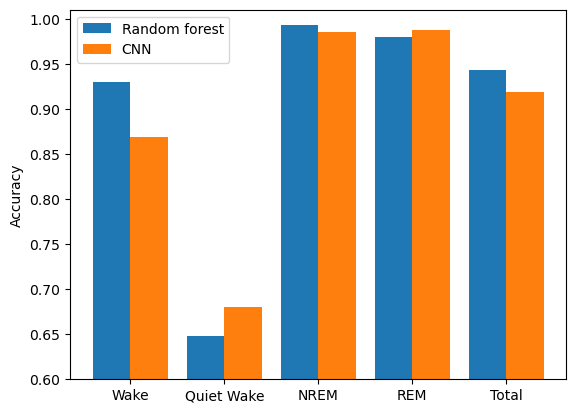

In [468]:
#Get accuracies by brain state
def GetAccState(cm):
    return np.diag(cm)/np.sum(cm,axis=1)

x_axis = np.arange(5)

accplotCNN = np.append(GetAccState(cm_CNNtest),acc_CNNtest/100)
accplot_rf = np.append(GetAccState(cm_rf_test),accuracy_rf_test)

labels_plot = ['Wake', 'Quiet Wake', 'NREM', 'REM','Total']

plt.bar(x_axis-0.2, accplot_rf, width=0.4, label='Random forest')
plt.bar(x_axis+0.2, accplotCNN, width=0.4, label='CNN')
plt.xticks(x_axis, labels_plot)
plt.ylim((0.6,1.01))
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# External test set

## Load and normalize data

In [351]:
#load data from mat file
extest_origin = loadmat('z:/ricardo/data/Project/State_classification/brain_state_test.mat')


In [ ]:
from sklearn.preprocessing import RobustScaler

In [352]:
spectral_norm_extest, mov_norm_extest = normalize_test(extest_origin,'spectrograms_test','movement_test',moveScaler)

In [353]:
target_extest = extest_origin['target_test'].ravel()

In [587]:
np.shape(spectral_norm_extest)

(4885, 101, 81)

In [355]:
#create data sampler for test set
data_extest = DataStates(mov_norm_extest, spectral_norm_extest,target_extest)
#extest_sampler = SubsetRandomSampler(range(len(data_test)),generator=torch.Generator().manual_seed(12))

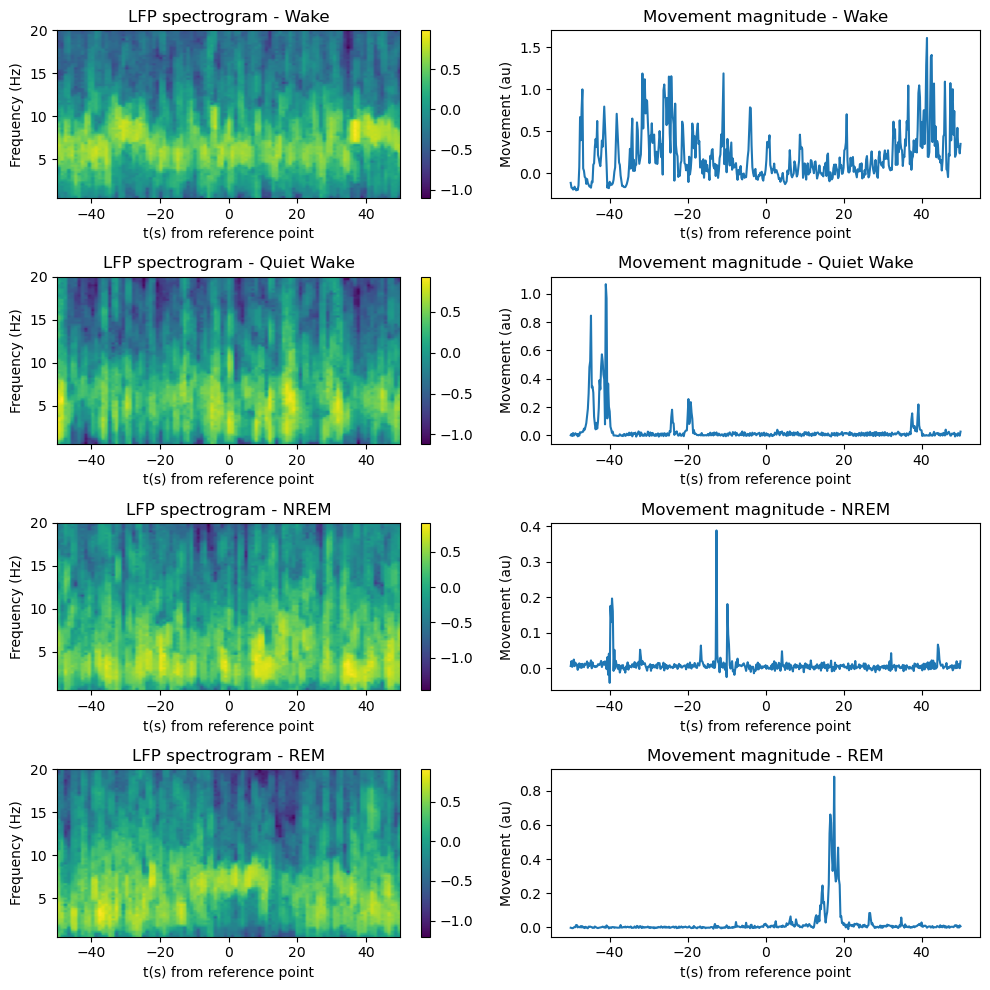

In [356]:
#pick indices corresponding to different classes
state_ind = [0, 0, 0, 0]
for i in np.arange(1,5):
    state_ind[i-1] = np.where(extest_origin['target_test']==i)[0][np.random.randint(100)]

state_labels = ['Wake', 'Quiet Wake', 'NREM','REM']
fig, axs = plt.subplots(4,2, figsize=(10,10))


for i, labl in enumerate(state_labels):
    #plot spectral data
    pcm = axs[i,0].imshow(spectral_norm_extest[state_ind[i],:,:].T, origin='lower',
    aspect='auto', extent=[-50,50,0.5,20])
    axs[i,0].set_title('LFP spectrogram - ' + labl)
    fig.colorbar(pcm, ax=axs[i,0])
    axs[i,0].set_xlabel('t(s) from reference point')
    axs[i,0].set_ylabel('Frequency (Hz)')
    
    #plot movement profile
    axs[i,1].plot(np.linspace(-50,50, num=501), mov_norm_extest[state_ind[i],:])
    axs[i,1].set_title('Movement magnitude - ' + labl)
    axs[i,1].set_xlabel('t(s) from reference point')
    axs[i,1].set_ylabel('Movement (au)')

fig.tight_layout()
plt.show()

    

## Test Random Forest performance

In [ ]:
#Check the hyperparameter values that gave the best accuracy
hebo_rf.best_x

,max_depth,min_samples_leaf,min_impurity_decrease,n_estimators,max_features
41,16,0.00014,0.000208,200,log2


In [56]:
dict_bestrf_x = {'max_depth': 16, 'min_samples_leaf':0.00014, 'min_impurity_decrease': 0.000208, 'n_estimators': 200, 'max_features': 'log2'}
bestrf_x = pd.DataFrame([dict_bestrf_x])
print(str(bestrf_x['max_features'][0]))

log2


In [357]:
cm_rf_tuned_extest, acc_rf_tuned_extest,_ = random_forest(data_train, len(data_train), data_extest, len(data_extest), hebo_rf.best_x.iloc[0,:])

Accuracy of the Random Forest is 0.819


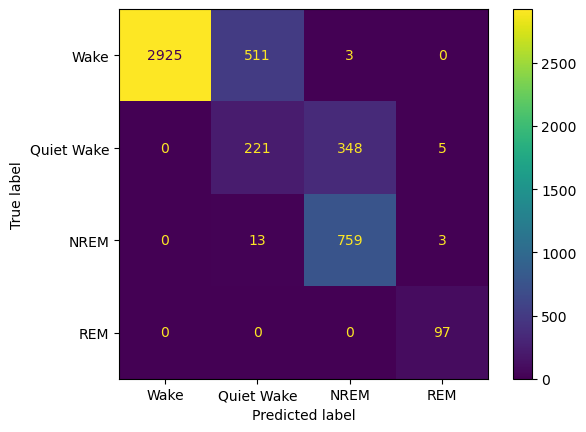

In [358]:
#Show performance
cmd_rf_tuned_extest = ConfusionMatrixDisplay(cm_rf_tuned_extest,display_labels=state_labels)
cmd_rf_tuned_extest.plot();
print('Accuracy of the Random Forest is', np.round(acc_rf_tuned_extest,3))

## Test neural network performance

In [86]:
Checkpoint('/Users/ricardo/Documents/VScode/brain_states/data/Model_checkpoints/net-capstone.pt')

5
3


In [469]:
#test performance in vali
cm_CNNextest, acc_CNNextest = test(net, data_extest, batch_size=len(data_extest))

Accuracy of the CNN on the test set is 74.882


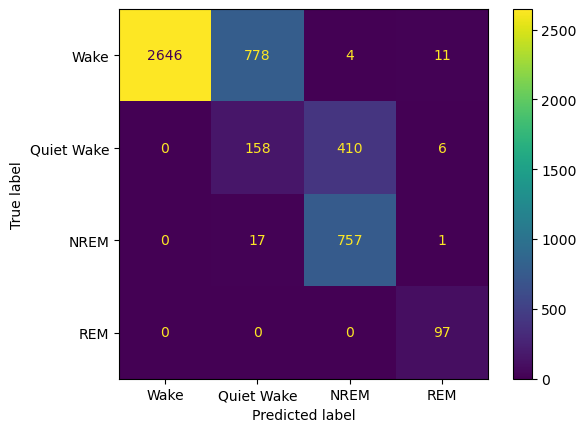

In [470]:
#Show performance
cmd_CNNextest = ConfusionMatrixDisplay(cm_CNNextest,display_labels=state_labels)
cmd_CNNextest.plot();
print('Accuracy of the CNN on the test set is', np.round(acc_CNNextest,3))

# Check wrong predictions

### Random Forest

In [472]:
def rf_predict(data_val,n_val, rf_clf):
    validation_loader = DataLoader(data_val,batch_size=n_val)

    valdata = iter(validation_loader)
    valdata = valdata.next()
    
    #reshape
    X_val = np.concatenate((valdata[0], 
    valdata[1].reshape(n_val,np.shape(valdata[1])[1]*np.shape(valdata[1])[2])),axis=1)
    y_val = valdata[2].ravel()

    #make predictions
    pred = rf_clf.predict(X_val)
    
    return pred

In [575]:
def checkWrong(pred,y,pred_state, y_state, spect, mov):

    print(pred_state, y_state)
    comp = np.array(pred==pred_state).reshape(-1,1)
    comp2 = np.array(y==y_state).reshape(-1,1)
    cmpt = np.sum(np.concatenate((comp,comp2),axis=1),axis=1)
    #print(np.shape(comp+comp2)[0])
    #print(np.shape(np.where(cmpt==2)[0]))
    len_evs = np.shape(np.where(np.logical_and(pred==pred_state,y==y_state))[0])[0]
    print(len_evs)

    wrong_ind = np.where(np.logical_and(pred==pred_state,y==y_state))[0][np.random.randint(len_evs,size=4)]
    print(wrong_ind)
    
    fig, axs = plt.subplots(4,2, figsize=(10,10))
    state_labels = ['Wake', 'Quiet Wake', 'NREM','REM']

    for i in range(4):
        #plot spectral data
        pcm = axs[i,0].imshow(spect[wrong_ind[i],:,:].T, origin='lower',
            aspect='auto', extent=[-50,50,0.5,20])
        axs[i,0].set_title('LFP spectrogram - ' + 'Predicted ' + state_labels[pred[wrong_ind[i]]] + ', Truth ' + state_labels[y[wrong_ind[i]]])
        fig.colorbar(pcm, ax=axs[i,0])
        axs[i,0].set_xlabel('t(s) from reference point')
        axs[i,0].set_ylabel('Frequency (Hz)')
    
        #plot movement profile
        axs[i,1].plot(np.linspace(-50,50, num=501), mov[wrong_ind[i],:])
        axs[i,1].set_title('Movement magnitude')
        axs[i,1].set_xlabel('t(s) from reference point')
        axs[i,1].set_ylabel('Movement (au)')

    fig.tight_layout()
    plt.show()

In [813]:
rf_predictions = rf_predict(data_val,len(data_val),best_rf)

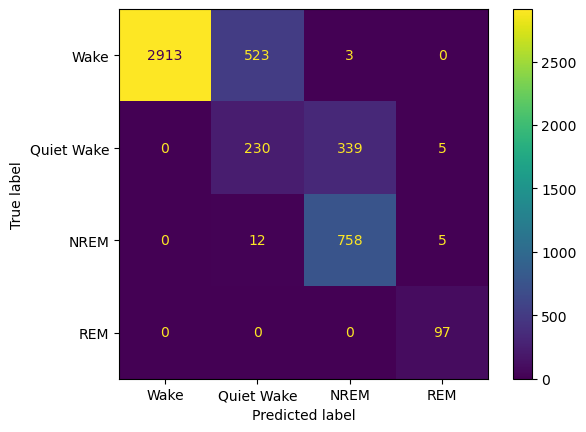

In [586]:
cm = confusion_matrix(target_extest,rf_predictions)
cmd = ConfusionMatrixDisplay(cm,display_labels=state_labels)
cmd.plot();

0 1
56
[568 554 564 478]


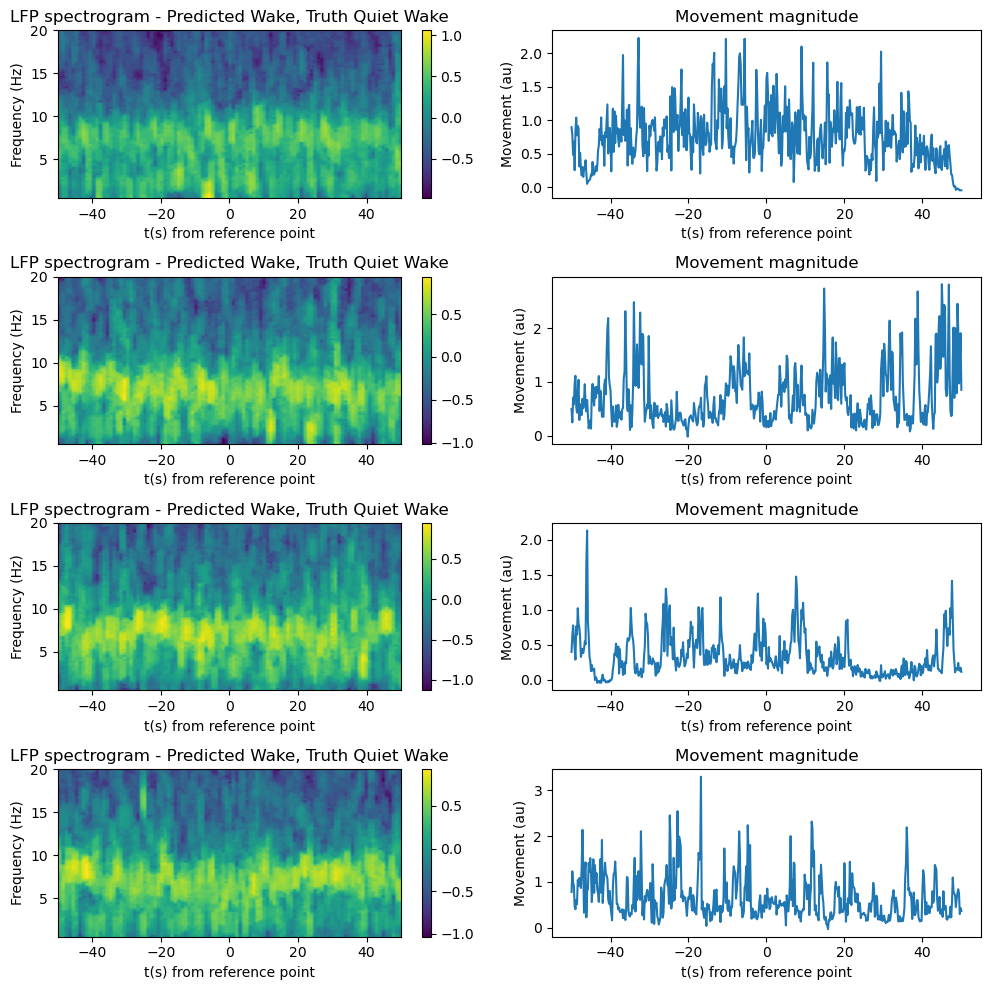

In [819]:
checkWrong(rf_predictions-1,target_val_res-1,0,1,spectral_norm_val_res,mov_norm_val_res)

### Neural network

In [737]:
def checkWrongNet(pred,y,pred_state, y_state, spect, mov, output):

    print(pred_state, y_state)
    comp = np.array(pred==pred_state).reshape(-1,1)
    comp2 = np.array(y==y_state).reshape(-1,1)
    cmpt = np.sum(np.concatenate((comp,comp2),axis=1),axis=1)
    #print(np.shape(comp+comp2)[0])
    #print(np.shape(np.where(cmpt==2)[0]))
    len_evs = np.shape(np.where(np.logical_and(pred==pred_state,y==y_state))[0])[0]
    print(len_evs)

    wrong_ind = np.where(np.logical_and(pred==pred_state,y==y_state))[0][np.random.randint(len_evs,size=4)]
    print(wrong_ind)
    
    fig, axs = plt.subplots(4,2, figsize=(10,10))
    state_labels = ['Wake', 'Quiet Wake', 'NREM','REM']

    for i in range(4):
        #plot spectral data
        pcm = axs[i,0].imshow(spect[wrong_ind[i],:,:].T, origin='lower',
            aspect='auto', extent=[-50,50,0.5,20])
        axs[i,0].set_title('LFP spectrogram - ' + 'Predicted ' + state_labels[pred[wrong_ind[i]]] + ', Truth ' + state_labels[y[wrong_ind[i]]])
        fig.colorbar(pcm, ax=axs[i,0])
        axs[i,0].set_xlabel('t(s) from reference point')
        axs[i,0].set_ylabel('Frequency (Hz)')
    
        #plot movement profile
        axs[i,1].plot(np.linspace(-50,50, num=501), mov[wrong_ind[i],:])
        axs[i,1].set_title('Movement magnitude' + str(output[wrong_ind[i],:]))
        axs[i,1].set_xlabel('t(s) from reference point')
        axs[i,1].set_ylabel('Movement (au)')

    fig.tight_layout()
    plt.show()

In [796]:
_,_, net_predictions, output_net =  test(net, data_val, batch_size=len(data_val))

In [680]:
np.unique(net_predictions)

array([0, 1, 2, 3], dtype=int64)

3 1
5
[548 377 402 333]


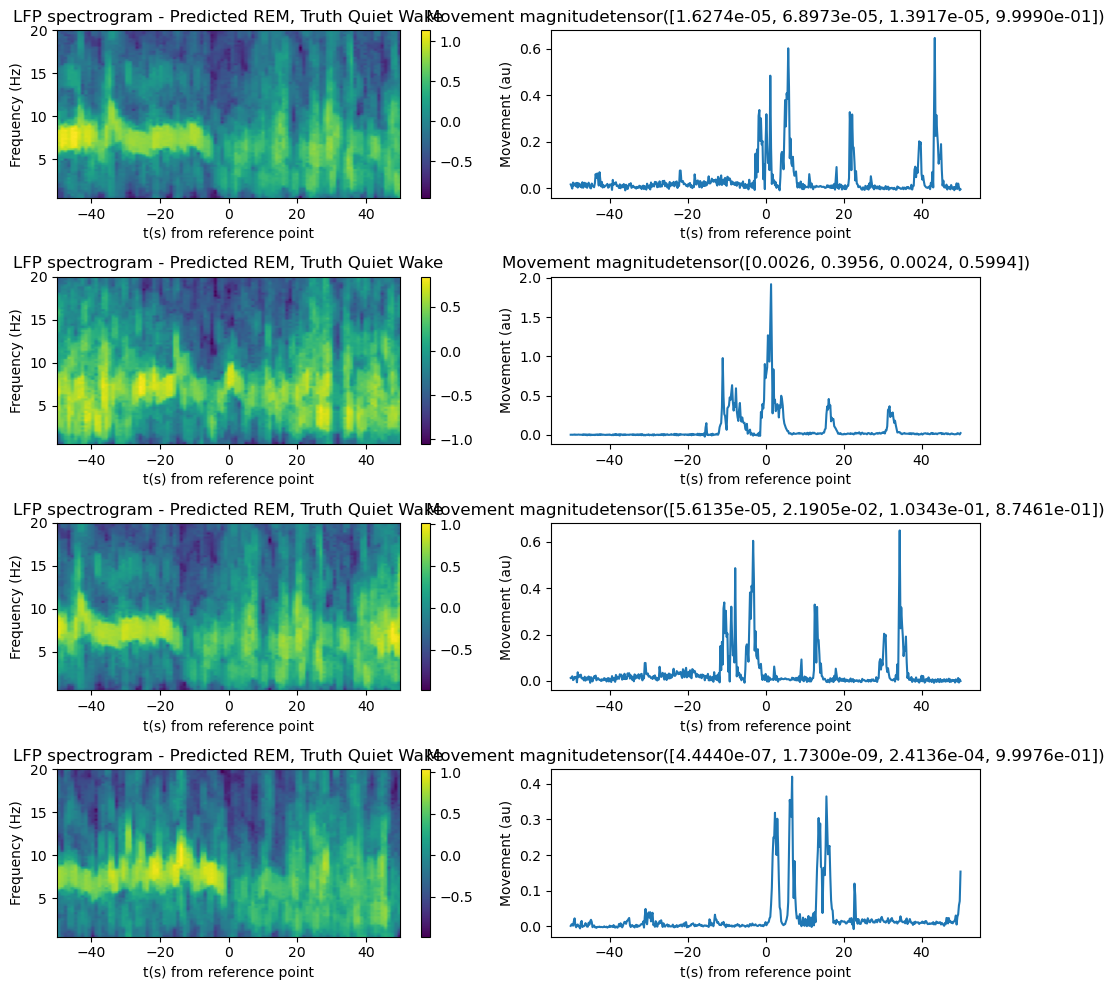

In [797]:
checkWrongNet(net_predictions,target_val_res-1,3,1,spectral_norm_val_res,mov_norm_val_res,output_net)

In [569]:
net

Net(
  (conv1): Conv2d(1, 11, kernel_size=(14, 14), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(11, 9, kernel_size=(14, 14), stride=(1, 1))
  (convtime): Conv1d(1, 2, kernel_size=(14,), stride=(1,))
  (pooltime): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1838, out_features=492, bias=True)
  (fc2): Linear(in_features=492, out_features=541, bias=True)
  (fc3): Linear(in_features=541, out_features=4, bias=True)
)

# Conclusions

From the comparison of the two models used, the overall accuracy of the CNN is slightly higher that that of the Random Forest (around 2% difference). However, taking a closer look at accuracies for the different classes it is noteworthy that the CNN performs considerably better on identifying quiet wake states than the Random Forest (almost 10% difference).
It should be mentioned that the distinction between the quiet wake and NREM sleep states is not straightforward. There is surely a certain level of uncertainty in the labeling of the quiet wake state because it is not possible to identify the axact transition point between QW and sleep solely based on these data.

Overall the CNN is the model I would use due to its better overall performance, as compared with the Random Forest.

# Remarks

Overal, the approaches used look promising and there is margin for improvements. One aspect that should be further explored is the tuning of further hyperparameters in the CNN, such as the number of filters used in the convolutions and the number of hidden layers.
It would also be useful to take a closer look at misclassified instances in order to identify possible explanations for prediction failure in those conditions. Those include possible limitations in the models but also errors in the labelling.

Another strategy to further improve predictive performance, and generalizabity is the extension of the training dataset to more animals.